<a href="https://colab.research.google.com/github/ayaka26/Exercises/blob/master/practice_0606_skipgram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# packageのimport
from typing import Any, Union, Callable, Type, TypeVar
from tqdm.auto import trange,tqdm
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
def build_onehot(id,vocab_size:int):
    onehot = np.zeros(vocab_size)
    onehot[id] = 1
    return onehot

#def build_onehot(id,vocab_size:int):
#    return np.eye(vocab_size)[id]

In [13]:
def build_bow(id_seq:list, vocab_size:int):
    bow = np.zeros(vocab_size)
    for id in id_seq:
        onehot = build_onehot(id, vocab_size)
        bow += onehot
    return bow

# [2,1,0,1,0]

In [14]:
class CBoW(nn.Module):
    def __init__(self, vocab_size:int, embedding_dim:int) -> None:
        super().__init__()
        self.embeddingbag = nn.EmbeddingBag(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs:Any)->Any:
        h = self.embeddingbag(inputs) / inputs.size(-1)
        return self.linear(h)

In [3]:
!wget https://s3-ap-northeast-1.amazonaws.com/dev.tech-sketch.jp/chakki/public/ja.text8.zip
!unzip ja.text8.zip

--2023-07-17 15:17:34--  https://s3-ap-northeast-1.amazonaws.com/dev.tech-sketch.jp/chakki/public/ja.text8.zip
Resolving s3-ap-northeast-1.amazonaws.com (s3-ap-northeast-1.amazonaws.com)... 52.219.68.132, 52.219.0.198, 52.219.199.96, ...
Connecting to s3-ap-northeast-1.amazonaws.com (s3-ap-northeast-1.amazonaws.com)|52.219.68.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33905114 (32M) [application/zip]
Saving to: ‘ja.text8.zip’

ja.text8.zip        100%[===================>]  32.33M  13.0MB/s    in 2.5s    

2023-07-17 15:17:37 (13.0 MB/s) - ‘ja.text8.zip’ saved [33905114/33905114]

Archive:  ja.text8.zip
  inflating: ja.text8                


In [4]:
with open("./ja.text8") as f:
    text8 = f.read()

In [5]:
def build_dictionary(texts):
    word2id = {}
    for 文 in texts:
        for 単語 in 文.split():
            if 単語 in word2id:
                continue
            word2id[単語] = len(word2id)
    print(word2id)


texts = text8[:10000].split("。")
word2id = build_dictionary(texts)

{'ちょん': 0, '掛け': 1, '（': 2, 'がけ': 3, '、': 4, '丁': 5, '斧': 6, '・': 7, '手斧': 8, 'と': 9, 'も': 10, '表記': 11, '）': 12, 'は': 13, '相撲': 14, 'の': 15, '決まり': 16, '手': 17, 'ひとつ': 18, 'で': 19, 'ある': 20, '自分': 21, '右': 22, '左': 23, '足': 24, '踵': 25, 'を': 26, '相手': 27, 'に': 28, '後方': 29, '捻っ': 30, 'て': 31, '倒す': 32, '技': 33, 'ちょう': 34, 'な': 35, 'かける': 36, '仕草': 37, '似': 38, 'いる': 39, 'こと': 40, 'から': 41, 'が': 42, '訛っ': 43, 'なっ': 44, 'た': 45, 'いわ': 46, 'れる': 47, '柔道': 48, '小内': 49, '刈': 50, 'ほぼ': 51, '同じ': 52, '動き': 53, '見せる': 54, '1944': 55, '年': 56, '1': 57, '月': 58, '場所': 59, '6': 60, '日': 61, '目': 62, '36': 63, '連勝': 64, '中': 65, '横綱': 66, '双葉': 67, '山': 68, '枩': 69, 'ノ': 70, '里': 71, '決め': 72, '金星': 73, '挙げ': 74, '最近': 75, '2014': 76, '11': 77, '7': 78, '常幸': 79, '龍': 80, '照': 81, '富士': 82, '2012': 83, '5': 84, '朝': 85, '赤': 86, '若': 87, 'この': 88, '勝利': 89, 'し': 90, 'ほか': 91, '十': 92, '両': 93, '12': 94, '天': 95, '鎧': 96, '鵬': 97, '双': 98, '大竜': 99, '2013': 100, '2': 101, '鬼': 102, '嵐': 103, '丹':

In [6]:
import re

def my_analyzer(text):
    #text = code_regex.sub('', text)
    tokens = text.split()
    tokens = filter(lambda token: re.search(r'[ぁ-ん]+|[ァ-ヴー]+|[一-龠]+', token), tokens)
    return tokens

def build_dictionary(texts, min_df=1):
    from sklearn.feature_extraction.text import CountVectorizer
    countvectorizer = CountVectorizer(min_df=min_df, analyzer=my_analyzer)

    X = countvectorizer.fit_transform(texts)
    id2word = {id:w for id,w in enumerate(countvectorizer.get_feature_names_out())}
    word2id = {w:id for id,w in id2word.items()}
    return id2word, word2id, X

texts = text8.split("。")
id2word, word2id,X = build_dictionary(texts,5)
V = len(id2word)
D = len(texts)
print(f"文書数: {D}, 語彙数: {V}")

文書数: 564194, 語彙数: 63269


In [7]:
from tqdm.auto import tqdm

def build_contexts_and_target(preprocessed_texts, window_size=5):
    contexts = []
    target = []
    a = window_size//2
    for text in tqdm(preprocessed_texts):
        for i in range(a, len(text)-a):
            target.append(text[i])
            tmp = text[i-a:i]
            tmp += text[i+1:i+1+a]
            contexts.append(tmp)
    return np.array(contexts), np.array(target)

In [8]:
WINDOW_SIZE = 11

preprocessed_texts = [[word2id[w] for w in text.split() if w in word2id] for text in texts]
preprocessed_texts = [text for text in preprocessed_texts if len(text) > WINDOW_SIZE]
contexts, target = build_contexts_and_target(preprocessed_texts, WINDOW_SIZE)
print("前処理後の文書数:", len(preprocessed_texts))
print(f"contextsの数: {len(contexts)}")

  0%|          | 0/454833 [00:00<?, ?it/s]

前処理後の文書数: 454833
contextsの数: 8109771


In [9]:
def get_batch(contexts, target, batch_size=32, shuffle=True):
    D = target.size
    index = np.arange(D)

    if shuffle:
        np.random.shuffle(index)

    n_batches = D // batch_size
    for minibatch_indexes in np.array_split(index, n_batches):
        a = torch.tensor(contexts[minibatch_indexes])
        b = torch.tensor(target[minibatch_indexes])
        yield a,b

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7919 [00:00<?, ?it/s]

  0%|          | 0/7919 [00:00<?, ?it/s]

  0%|          | 0/7919 [00:00<?, ?it/s]

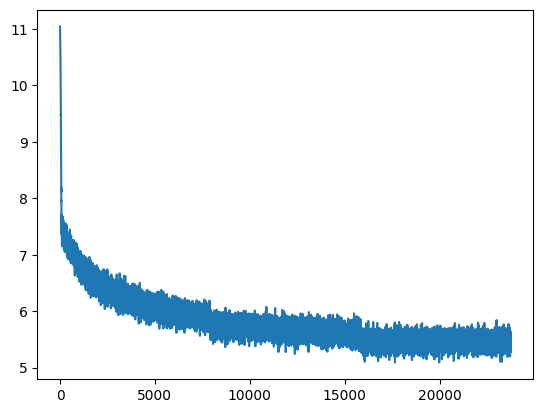

In [15]:
# hyper-params
max_epochs = 3 # 3
lr = 0.01
batch_size = 1024 # 1024
L = 50

n_batches = len(target) // batch_size
if torch.cuda.is_available():
    DEVICE ="cuda:0" # 0番目のグラボを使え.
else:
    DEVICE = "cpu"

# define models
cbow = CBoW(V, L).to(DEVICE)
optimizer = optim.Adam(cbow.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# training loop
monitoring_loss = []
for epoch in trange(max_epochs):
    with tqdm(total=n_batches) as tbar:
        for batch in get_batch(contexts, target, batch_size):
            x,y = batch
            x,y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            logits = cbow(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            monitoring_loss.append(float(loss))
            tbar.update(1)

# plot
plt.plot(monitoring_loss)

In [18]:
word_embeddings = list(cbow.embeddingbag.parameters())[0].data.detach().cpu().numpy()
def get_similar_words(query:str, topn:int=5,
                      word2id=word2id,
                      word_embeddings=word_embeddings):
    # 始
    id = word2id[query]
    target_vector = word_embeddings[id]
    # target_vectorとword_embeddingsとのコサイン類似度の計算
    # コサイン類似度が大きい順にargsort
    # 上位topn個の単語を例の様にprintする
    # 終

word_embeddings = list(cbow.embeddingbag.parameters())[0].data.detach().cpu().numpy()
def get_similar_words(query:str, topn:int=5,
                      word2id=word2id,
                      word_embeddings=word_embeddings):
    id=word2id[query]
    E = word_embeddings.T / np.linalg.norm(word_embeddings,ord=2, axis=1)
    target_vector = E[:,id]
    cossim = target_vector @ E # (K)@(K, V)->(V)
    sorted_index = np.argsort(cossim)[::-1][1:topn+1]
    print(f">>> {query}")
    for i in sorted_index:
        print(f"{id2word[i]} \t{cossim[i]}")

In [27]:
get_similar_words("サッカー")
get_similar_words("日本")
get_similar_words("女王")
get_similar_words("機械学習")# text8にない？

>>> サッカー
バスケットボール 	0.8563511967658997
ラグビー 	0.8035283088684082
ホッケー 	0.7784405946731567
フットボール 	0.7390976548194885
野球 	0.730502188205719
>>> 日本
アメリカ 	0.6093581318855286
戦中 	0.5604157447814941
戦後 	0.5545344948768616
韓国 	0.5509508848190308
中国 	0.538772702217102
>>> 女王
王妃 	0.7259100675582886
エリザベス 	0.725229799747467
アルバート 	0.7150346636772156
ステュアート 	0.7000333666801453
メアリー 	0.6879456043243408


KeyError: ignored